In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import models

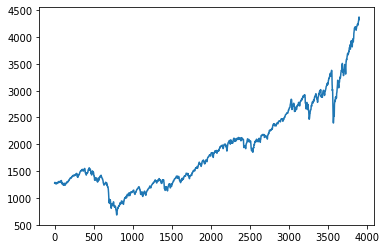

3904
2.0
1277.4633333333334
E_y2  1631944.4615000002
E_xy  2558.9233333333336
E_x2  4.666666666666667
[1273.46, 1273.48, 1285.45]
m  5.995000000000343
1265.4733333333327
MAX LENGTH:21


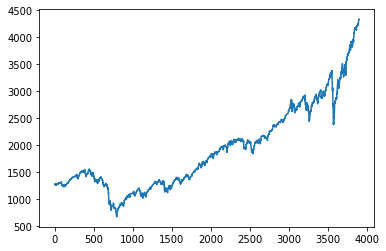

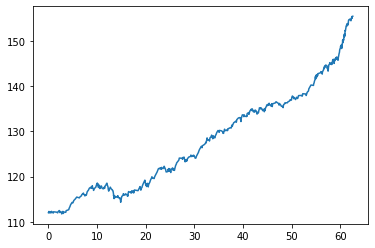

In [47]:
import utils.polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

# read in time series into temporary list
temp = []
f = open('DataSets/snp500.csv', 'r')
for line in f.readlines():
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
temp = pla.median_filter(temp, 5)
data, max_len = pla.sliding_window_pla(temp, 100)#pla.sliding_window_pla(temp,0.001)
pla.display_trends(data, 112)

In [3]:
class BiLSTM_TEST(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        
        self.LSTM = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            bidirectional=True,
            dropout=0.2
        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers * 2, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers * 2, x.size(0), self.hidden_size))
        output, (hidden, _) = self.LSTM(x, (h_0, c_0))
        out = output[:, -1, :]
        out = self.dropout(out)

        return self.fc(out)

In [49]:
seq_length = 2
train_proportion = 0.8
val_test = 0.5


seq_length*=2
def sliding_window(data):
    inputs = []
    outputs = []
    input_numpy = []
    out_numpy = []
    for i in range(0, len(data)-seq_length, 2):
        #inputs.append(data[i:(i+seq_length)]) # the next n are the input
        #outputs.append(data[i+seq_length:i+seq_length+2]) # and the one after that is the output
        input_numpy.append(np.array(data[i:(i+seq_length)]).reshape(int(seq_length/2),2))
        out_numpy.append(np.array(data[i+seq_length:i+seq_length+1]))
        
    return Variable(torch.Tensor(input_numpy)), Variable(torch.Tensor(out_numpy))

# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

validation_index = int((len(total_data_input) - train_size)*val_test) #Calculates how many data points in the validation set
testing_index = len(total_data_input) - train_size - validation_index;

print(total_data_input.shape)
validation_data_input = torch.narrow(total_data_input, 0, train_size, validation_index)
validation_data_output = torch.narrow(total_data_output, 0, train_size, validation_index)
print(validation_data_input[0])

testing_data_input = torch.narrow(total_data_input, 0, train_size+validation_index, testing_index)
testing_data_output = torch.narrow(total_data_output, 0, train_size+validation_index, testing_index)
print(testing_data_input[0])

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
validate = torch.utils.data.TensorDataset(validation_data_input, validation_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)



trainset = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False)
validateset = torch.utils.data.DataLoader(validate, batch_size=64, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)

torch.Size([769, 2, 2])
tensor([[-0.9139,  0.2381],
        [-0.6470,  0.1905]])
tensor([[ 0.9729,  0.0952],
        [-0.7929,  0.1905]])


In [50]:
epochs = 2000
learning_rate = 0.001
num_classes = 1
input_size = 2
hidden_size = 64
num_layers = 1

model = models.BiLSTM(num_classes, input_size, hidden_size, num_layers)

Epoch: 0/2000, loss: 0.7879354953765869
Epoch: 200/2000, loss: 0.840957760810852
Epoch: 400/2000, loss: 0.7981226444244385
Epoch: 600/2000, loss: 0.820527970790863
Epoch: 800/2000, loss: 0.7994350790977478
Epoch: 1000/2000, loss: 0.8841307759284973
Epoch: 1200/2000, loss: 0.9456189870834351
Epoch: 1400/2000, loss: 0.9405179619789124
Epoch: 1600/2000, loss: 0.8775668740272522
Epoch: 1800/2000, loss: 0.9451341032981873
Epoch: 2000/2000, loss: 0.696941077709198


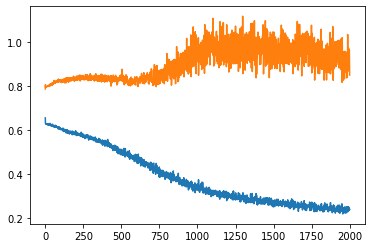

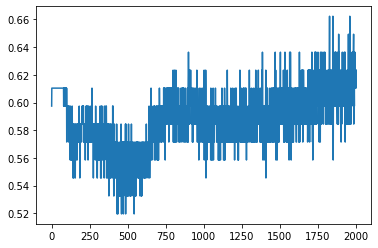

Lowest validation loss: 0.7856605350971222 at epoch 0


In [51]:
import torch.optim as optim
train_loss = []
validation_loss = []
epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 1000000 # the lowest validation loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_direction_accuracy = []
validation_direction_accuracy = []
for epoch in range(epochs+1):

   
    for i, (trainX, trainY) in enumerate(trainset):  # for each batch
        model.train()
        model.zero_grad()
        output = model(trainX)  # get a prediction from the model
        loss = F.mse_loss(output, trainY)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)  # sum the losses of this epoch
    
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch


 # this is the validation part, ideally we wouldn't do this every epoch, but it's easy and
    # gives good insight into when the model overfits
    with torch.no_grad():
        for i, (trainX, trainY) in enumerate(validateset):
            model.eval()
            model.zero_grad()
            output = model(trainX)  # get a prediction from the model
            loss = F.mse_loss(output, trainY)  # calculate the loss of our prediction
            epoch_total_trainloss += loss.item()/len(validateset)
        
        if epoch_total_trainloss < min_val_loss:
            torch.save(model.state_dict(), 'model_results.pt')
            min_val_loss = epoch_total_trainloss
            min_val_loss_epoch = epoch

        validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
        epoch_total_trainloss = 0 # reset this for the validation epoch'''


        # now we'll calculate the direction accuracy for the training and validation sets
        correct=0
        cnt=0
        
        for i, (trainX, trainY) in enumerate(validateset):
            output = model(trainX)
            cnt+=len(output)
            for x in range(len(output)):

                if output[x]>0 and trainY[x]>0 or output[x]<0 and trainY[x]<0:
                    correct+=1 
                #print(output[0],labels[0])
        validation_direction_accuracy.append(correct/cnt)

    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")


    

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")